# Détection de zones brûlées sur images satellites
Objectif : Développer un modèle de détection d’objets capable d’identifier et de localiser les zones brûlées sur des images satellites pour permettre une détection et un suivi des incendies, faire de la prévention, etc.
Entrée : images satellites 
Sortie attendue : rectangles englobants les zones brûlées sur l’image
→ Tâche de vision par ordinateur : détection d’objets


In [80]:
# Import
import json
from pathlib import Path

## Dataset - lecture
On dispose d’un jeu de données (zip en ressource du brief) comprenant : 
des photos satellite
les annotations correspondantes dans le fichier _annotations.coco.json 
source du dataset

- Regarder la doc et ouvrir le fichier : quelles sont les informations fournies ? 
→ Adapter l’affichage json dans VSCode pour Windows : Shift + Alt + F, pour Mac : Shift + Option + F

- Ajouter une fonction dans un fichier data_loader.py pour lire le fichier en utilisant json.load. 

- Ajouter une fonction qui charge les données dans des dataframes 


In [81]:
import json
from pathlib import Path

def load_json(file_path: str | Path) -> dict:
    """
    Lit un fichier JSON et retourne son contenu sous forme de dictionnaire.

    Args:
        file_path (str | Path): Chemin vers le fichier JSON.

    Returns:
        dict: Contenu du fichier JSON.

    Raises:
        FileNotFoundError: Si le fichier n’existe pas.
        json.JSONDecodeError: Si le contenu n'est pas un JSON valide.
    """
    file_path = Path(file_path)

    if not file_path.exists():
        raise FileNotFoundError(f"Le fichier {file_path} n’existe pas.")

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        raise ValueError(f"Le fichier {file_path} n'est pas un JSON valide : {e}")

    return data



file_path = Path("/home/nabil_simplon/wildfire-detection/data/_annotations.coco.json")
data = load_json(file_path)

# Vérification du fichier chargé
print(type(data))  # devrait afficher <class 'dict'>
print(data.keys()) # montre les clés principales du JSON
print(data)


<class 'dict'>
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
{'info': {'year': '2025', 'version': '2', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2025-09-14T12:06:19+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'wildfire', 'supercategory': 'none'}, {'id': 1, 'name': 'fire', 'supercategory': 'wildfire'}], 'images': [{'id': 0, 'license': 1, 'file_name': 'cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf.479904c9e54c6ba121689341598bf3ed.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:19+00:00', 'extra': {'name': 'cl6e1qges001kgk555z158f33_2_FALSE_COLOR.jpg'}}, {'id': 1, 'license': 1, 'file_name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf.95debd80b7509cc0a6afe0a7c7ff6cfe.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:1

In [82]:
import pandas as pd
import json
from typing import Union

def load_json_as_dataframe(data: Union[dict, list]) -> pd.DataFrame:
    """
    Convertit un objet JSON (dict ou list de dicts) en DataFrame pandas.

    Args:
        data (dict ou list): Données JSON déjà chargées.

    Returns:
        pd.DataFrame: Contenu du JSON sous forme de DataFrame.

    Raises:
        ValueError: Si le contenu JSON n'est pas compatible avec DataFrame.
    """
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        raise ValueError("Le contenu JSON n'est pas un format compatible avec DataFrame")

    return df


In [83]:
export_data_to_df = load_json_as_dataframe(data)
display(export_data_to_df)

,info,licenses,categories,images,annotations
0,"{'year': '2025', 'version': '2', 'description'...","[{'id': 1, 'url': 'https://creativecommons.org...","[{'id': 0, 'name': 'wildfire', 'supercategory'...","[{'id': 0, 'license': 1, 'file_name': 'cl6e1qg...","[{'id': 0, 'image_id': 1, 'category_id': 1, 'b..."


## Exploration & nettoyage des données 


### a. Explorer les données pour en extraire les informations suivantes : 

- Nombre total d’image
- Nombre total d’annotations
- Quelles sont les catégories ?
- Nombre d’image par catégories
- Des statistiques sur le nombre d’annotation par image
etc…

Ajouter au moins 4 petites fonctions d’exploration dans un fichier data_explorer.py

Le dataframe est sous forme imbriqué : on va donc créer un dataframe pour la colonne 'Images', 'Annotations', 'catégories' : 

In [84]:
# Création du dataframe 'Images'
df_images = pd.DataFrame(data['images'])
display(df_images)

nombres_images = len(df_images)
print(f"Nombres d'images : {nombres_images}")

,id,license,file_name,height,width,date_captured,extra
0,0,1,cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6e1qges001kgk555z158f33_2_FALSE_CO...
1,1,1,cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_CO...
2,2,1,cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COL...
3,3,1,cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b6pieh007rl455fwvb73gr_1_TRUE_COL...
4,4,1,cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b5k38g003zl455bgtd1317_4_FALSE_CO...
...,...,...,...,...,...,...,...
495,495,1,cl6b5yjxa005nl45516k465kb_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b5yjxa005nl45516k465kb_1_TRUE_COL...
496,496,1,cl6opv5oo007xao553de9g7wd_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6opv5oo007xao553de9g7wd_2_FALSE_CO...
497,497,1,cl6cteplg00hkl4551scr5fko_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6cteplg00hkl4551scr5fko_1_TRUE_COL...
498,498,1,cl6b652mi0068l4552keu9loj_6_SWIR_jpg.rf.113908...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b652mi0068l4552keu9loj_6_SWIR.jpg'}


Nombres d'images : 500


In [85]:
# Création du dataframe 'annotations'
df_annotations = pd.DataFrame(data['annotations'])
display(df_annotations)

nombres_annotations = len(df_annotations)
print(f"Nombres d'annotations : {nombres_annotations}")

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,1,1,"[277, 207, 568.95, 591.79]",336698.921,[],0
1,1,2,1,"[800, 0, 157.45, 413.38]",65086.681,[],0
2,2,2,1,"[1062, 96, 58.37, 63.91]",3730.427,[],0
3,3,2,1,"[452, 442, 410.09, 350.6]",143777.554,[],0
4,4,2,1,"[0, 163, 336.16, 375.08]",126086.893,[],0
...,...,...,...,...,...,...,...
954,954,496,1,"[80, 30, 416.05, 183.75]",76449.188,[],0
955,955,496,1,"[0, 345, 140.33, 146.25]",20523.263,[],0
956,956,497,1,"[389, 361, 333, 340.52]",113393.160,[],0
957,957,498,1,"[510, 270, 222.6, 245.95]",54748.470,[],0


Nombres d'annotations : 959


In [86]:
# Création du dataframe 'catégories'
df_categories = pd.DataFrame(data['categories'])
display(df_categories)

nombres_categories = len(df_categories)
print(f"Nombres de catégories : {nombres_categories}")


,id,name,supercategory
0,0,wildfire,none
1,1,fire,wildfire


Nombres de catégories : 2


La raison pour laquelle on fait un merge entre df_annotations et df_categories est liée à la structure des données COCO :

df_annotations contient :

- image_id → l’ID de l’image où se trouve l’annotation

- category_id → l’ID de la catégorie de l’objet annoté

- Mais il n’y a pas le nom réel de la catégorie, juste son ID (par exemple 0 ou 1).

df_categories contient :

- id → le même category_id que dans les annotations

- name → le nom humain de la catégorie (fire ou wildfire)

images (id)  ←→  annotations (image_id, category_id)  ←→  categories (id)


In [87]:
# On merge df_annotations avec df_categories afin de pouvoir avoir le nombre d'image par category, car il n'y'a pas de foreign key entre images et categories:
# merge = combine les infos pour compter par nom au lieu de l'ID.

df_merged = df_annotations.merge(df_categories,left_on='category_id', right_on='id')

# Nombre d'images distinctes par catégorie
df_images_par_categories = df_merged.groupby("name")["image_id"].nunique()

display(df_images_par_categories)

name
fire    493
Name: image_id, dtype: int64

unique() :

Renvoie toutes les valeurs uniques d’une série ou d’une colonne sous forme de tableau/array.

nunique() :

Renvoie le nombre de valeurs uniques.

In [88]:
# Nombres d'annotations par images
df_merged_a_i = df_annotations.merge(df_images,left_on='image_id', right_on='id')

annotations_par_image = df_merged_a_i.groupby("file_name")["image_id"].count()

print(annotations_par_image)

file_name
cl6az56oy0003f05554mh92wy_2_FALSE_COLOR_jpg.rf.80849284d2ee075dcfd0d457f4c20b7a.jpg           1
cl6azgmfw0004f0557iqa1usw_6_SWIR_jpg.rf.0f5204c03b972113e76c964eada21109.jpg                  2
cl6azt6by0000go55h4io4tab_2_FALSE_COLOR_jpg.rf.7bd6bf61c42f8477a59d290789795964.jpg           2
cl6azt6by0000go55h4io4tab_6_SWIR_jpg.rf.f8a793559d8103b9c237ca96944514b5.jpg                  2
cl6azvz950000t0552g8v22is_1_TRUE_COLOR_jpg.rf.9324abe7caa6850140e03d5454f3abb4.jpg            1
                                                                                             ..
cl6ou8fz600abao5561sobj5z_1_TRUE_COLOR_jpg.rf.1ff7bea9ba4b1da2adb2975211554bc8.jpg            1
cl6oui3xy00aoao55d29e9vlz_4_FALSE_COLOR__URBAN_jpg.rf.75cb4ab2e4d84a20ae05d606f0cd9f7e.jpg    1
cl6ouiflj00apao55ef14ha2q_6_SWIR_jpg.rf.847b99640495bcb4aa215b63c1c3cde6.jpg                  1
cl6oujpxm00atao554qpycnsr_2_FALSE_COLOR_jpg.rf.80ca6bf8c90969f299e1fa5127fc8523.jpg           4
cl6oul0ve00axao5549vy6mom_4_FA

Moyenne : 1.95
Médiane : 1.0
Écart-type : 1.41
Minimum : 1
Maximum : 10


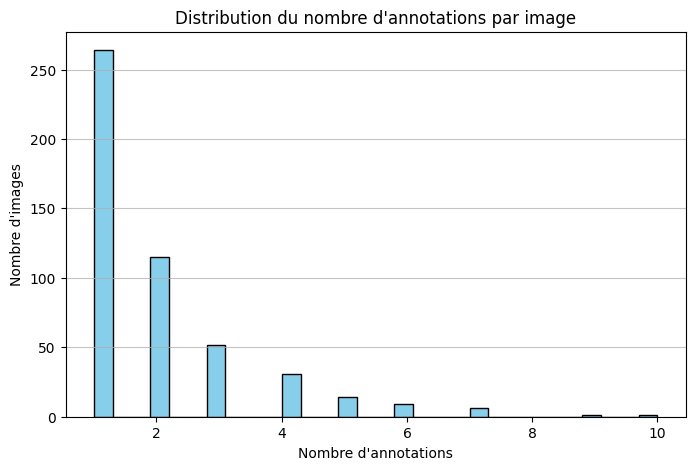

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que df_merged_a_i est le DataFrame fusion née du merge annotations/images
# Compter le nombre d'annotations par image (fichier)
annotations_par_image = df_merged_a_i.groupby("file_name")["image_id"].count()

# Calcul des statistiques principales
mean_val = annotations_par_image.mean()
median_val = annotations_par_image.median()
std_val = annotations_par_image.std()
min_val = annotations_par_image.min()
max_val = annotations_par_image.max()

# Afficher les statistiques
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val}")
print(f"Écart-type : {std_val:.2f}")
print(f"Minimum : {min_val}")
print(f"Maximum : {max_val}")

# Visualiser la distribution avec un histogramme
plt.figure(figsize=(8,5))
annotations_par_image.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution du nombre d'annotations par image")
plt.xlabel("Nombre d'annotations")
plt.ylabel("Nombre d'images")
plt.grid(axis='y', alpha=0.75)
plt.show()


Ajouter au moins 4 petites fonctions d’exploration dans un fichier data_explorer.py

### b. Vérification des incohérences dans les données 

Dans un fichier data_cleaner.py :
- Ecrire une fonction qui renvoie les extensions des fichiers :
Possibilité d’utiliser une boucle for ou compréhension de liste sur tous les fichiers d’un dossier avec os ou pathlib (cf 2 premiers exemples de cette page)
- Ecrire une fonction qui vérifie la cohérence entre les images disponibles et les images présentes dans _annotations.coco.json
- Ecrire une fonction qui renvoie la liste des images sans annotations s’il y en a
Piste de raisonnement
- Créer une liste d’id unique dans les annotations (pandas unique)
- Filtrer le dataframe d’images en ne gardant que les images telles que l’id ne soient pas dans la liste d’id unique (exemple pandas)
- Afficher pour vérifier leur contenu par exemple avec : 

from PIL import Image
img = Image.open(image_path)

- Écrire une fonction qui renvoie les annotations ne correspondant à aucune image
- Écrire une fonction qui détecte les valeurs aberrantes pour les annotations (ex : hauteur == 0 et largeur != 0, etc)


In [90]:
print(df_images)

      id  license                                          file_name  height  \
0      0        1  cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...     860   
1      1        1  cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf...     860   
2      2        1  cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf....     860   
3      3        1  cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf....     860   
4      4        1  cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN...     860   
..   ...      ...                                                ...     ...   
495  495        1  cl6b5yjxa005nl45516k465kb_1_TRUE_COLOR_jpg.rf....     860   
496  496        1  cl6opv5oo007xao553de9g7wd_2_FALSE_COLOR_jpg.rf...     860   
497  497        1  cl6cteplg00hkl4551scr5fko_1_TRUE_COLOR_jpg.rf....     860   
498  498        1  cl6b652mi0068l4552keu9loj_6_SWIR_jpg.rf.113908...     860   
499  499        1  cl6kjhhl5001h8w55fo1v1vqs_1_TRUE_COLOR_jpg.rf....     860   

     width              date_captured  

In [91]:
from pathlib import Path

def list_file_extensions(folder_path):
    """
    Retourne les extensions (dernière extension seulement) de tous les fichiers dans un dossier.
    """
    folder = Path(folder_path)
    extensions = [file.suffix.lower() for file in folder.rglob('*') if file.is_file()]
    return extensions

# Exemple d'utilisation
exts = list_file_extensions('/home/nabil_simplon/wildfire-detection/data')

unique_exts = sorted(set(exts))
print(unique_exts)


['.jpg', '.json']


In [92]:
# - Ecrire une fonction qui vérifie la cohérence entre les images disponibles et les images présentes dans _annotations.coco.json
from pathlib import Path

# Récupérer le chemin du dossier
racine = Path.home()
path_coco = racine / 'wildfire-detection/data/'
# print(path_coco)

# Récupérer tous les fichiers et dossiers à l'intérieur d'un dossier,

dossier_images = []

for file in Path(path_coco).rglob('*'):
    if file.is_file():
        dossier_images.append(file.stem)
    # print(dossier_images)



fichiers_dans_dossier = Path("/home/nabil_simplon/wildfire-detection/data")
print(f"Le fichier existe : {fichiers_dans_dossier.exists()}")




Le fichier existe : True


In [93]:
    # Liste des images .jpg présentes sur le disque, insensible à la casse
images_disk = set(f.name.lower() for f in Path(fichiers_dans_dossier).iterdir()
                     if f.is_file() and f.suffix.lower() == '.jpg')

print(len(images_disk))
print(len(images_disk))

500
500


In [94]:
print(len(df_images['file_name']))

500


In [95]:
import os
import json
from pathlib import Path

def check_image_coherence(image_folder, coco_json_path):
    """
    Vérifie la cohérence entre les images .jpg d'un dossier et les images listées dans un fichier COCO JSON.

    Args:
        image_folder (str): Le chemin du dossier contenant les images.
        coco_json_path (str): Le chemin du fichier COCO JSON.

    Returns:
        dict: Contenant :
            - 'absents_sur_disque': images référencées dans le JSON mais absentes du dossier
            - 'non_annotees': images sur disque non référencées dans le JSON
            - 'total_disk': nombre total de fichiers .jpg trouvés sur le disque
            - 'total_json': nombre total d'images .jpg listées dans le JSON
    """
    # Liste des images .jpg présentes sur le disque, insensible à la casse
    images_disk = set(f.name.lower() for f in Path(image_folder).iterdir()
                     if f.is_file() and f.suffix.lower() == '.jpg')

    # Lecture des images annotées dans le JSON
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)
        
    images_json = set(img['file_name'].lower() for img in coco.get('images', [])
                      if img['file_name'].lower().endswith('.jpg'))

    absents_sur_disque = images_json - images_disk
    non_annotees = images_disk - images_json

    return {
        'absents_sur_disque': absents_sur_disque,
        'non_annotees': non_annotees,
        'total_disk': len(images_disk),
        'total_json': len(images_json)
    }

# Exemple d'utilisation :
result = check_image_coherence(fichiers_dans_dossier, fichiers_dans_dossier / "_annotations.coco.json")
print("Images référencées dans le JSON absentes du disque :", result['absents_sur_disque'])
print("Images présentes sur le disque mais absentes dans le JSON :", result['non_annotees'])
print("Total sur disque :", result['total_disk'])
print("Total dans JSON :", result['total_json'])


Images référencées dans le JSON absentes du disque : set()
Images présentes sur le disque mais absentes dans le JSON : set()
Total sur disque : 500
Total dans JSON : 500


In [96]:
#Ecrire une fonction qui renvoie la liste des images sans annotations s’il y en a : 

def images_sans_annotations(df_images, df_annotations):
    # Jointure annotations→images pour associer file_name aux annotations
    df_merge = df_annotations.merge(df_images, left_on='image_id', right_on='id', how='right')
    
    # Compter le nombre d'annotations par image (file_name)
    annotations_par_image = df_merge.groupby('file_name')['id_x'].count()  # id_x est issu de df_annotations

    # Extraire les images avec 0 annotation
    images_sans_annots = annotations_par_image[annotations_par_image == 0].index.tolist()
    
    return images_sans_annots

images_sans_annotations = images_sans_annotations(df_images=df_images, df_annotations=df_annotations)
print(f"Nombres d'images sans annototaions : " , len(images_sans_annotations))
print(f"Listes d'images sans annototaions : " , images_sans_annotations)

Nombres d'images sans annototaions :  7
Listes d'images sans annototaions :  ['cl6b5myi60048l45530d5anq4_1_TRUE_COLOR_jpg.rf.1b9e229b9d66a61c1d9a410fd8ad6f23.jpg', 'cl6b5x63r005il4551chxdt93_2_FALSE_COLOR_jpg.rf.8c4fb06b6812031edb1ad781ec14d2b9.jpg', 'cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf.479904c9e54c6ba121689341598bf3ed.jpg', 'cl6e2kygp002egk55asrs2brz_1_TRUE_COLOR_jpg.rf.2a198a37785242fb6db3ef21c0ffdcad.jpg', 'cl6e3enfn003sgk554uim9wo6_1_TRUE_COLOR_jpg.rf.beaf169c01f4596cb24c1c4628ef21f1.jpg', 'cl6kf5xzo000gc4552qc8hhcc_2_FALSE_COLOR_jpg.rf.8fbfb16c6d86076d860904397218acd5.jpg', 'cl6kfx47x001tc45578ts0yz6_2_FALSE_COLOR_jpg.rf.5a9501946306fabdad807a6acb61ccbe.jpg']


In [97]:
# Créer une liste d’id unique (image) dans les annotations (pandas unique)
unique_image_ids_list = df_annotations['image_id'].unique().tolist()
print(f"Nombres d'images avec id unique : " , len(unique_image_ids_list))
print(unique_image_ids_list)

set_unique_image_ids_list = set(unique_image_ids_list)
print(set_unique_image_ids_list)

Nombres d'images avec id unique :  493
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 21

In [98]:
# Filtrer le dataframe d’images en ne gardant que les images telles que l’id ne soient pas dans la liste d’id unique (exemple pandas)

# Filtrer df_images pour ne garder QUE les images dont id n'est PAS dans la liste image_ids_unique
df_images_sans_annotations = df_images[~df_images['id'].isin(unique_image_ids_list)] # ~ inverse cette série, donc True pour les lignes dont l’id n’est pas dans la liste.
print(f"Nombres d'images avec id absent de la liste d'id unqiue  : " , len(df_images_sans_annotations))


print(f"Images sans annotations: ,  {df_images_sans_annotations['file_name']}")


Nombres d'images avec id absent de la liste d'id unqiue  :  7
Images sans annotations: ,  0      cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...
96     cl6kf5xzo000gc4552qc8hhcc_2_FALSE_COLOR_jpg.rf...
118    cl6e2kygp002egk55asrs2brz_1_TRUE_COLOR_jpg.rf....
122    cl6e3enfn003sgk554uim9wo6_1_TRUE_COLOR_jpg.rf....
209    cl6kfx47x001tc45578ts0yz6_2_FALSE_COLOR_jpg.rf...
290    cl6b5x63r005il4551chxdt93_2_FALSE_COLOR_jpg.rf...
451    cl6b5myi60048l45530d5anq4_1_TRUE_COLOR_jpg.rf....
Name: file_name, dtype: object


In [99]:
import os

# Vérifier si chaque fichier existe
for filepath in df_images_sans_annotations['file_name']:
    if not os.path.exists(filepath):
        print(f"Fichier manquant : {filepath}")
    else:
        print(f"Fichier trouvé : {filepath}")

import os

# Répertoire contenant les images
image_dir = "/chemin/vers/ton/dossier/images"

# Mettre à jour les chemins d'accès dans le DataFrame
df_images_sans_annotations['file_name'] = df_images_sans_annotations['file_name'].apply(
    lambda x: os.path.join(image_dir, os.path.basename(x))
)

Fichier manquant : cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf.479904c9e54c6ba121689341598bf3ed.jpg
Fichier manquant : cl6kf5xzo000gc4552qc8hhcc_2_FALSE_COLOR_jpg.rf.8fbfb16c6d86076d860904397218acd5.jpg
Fichier manquant : cl6e2kygp002egk55asrs2brz_1_TRUE_COLOR_jpg.rf.2a198a37785242fb6db3ef21c0ffdcad.jpg
Fichier manquant : cl6e3enfn003sgk554uim9wo6_1_TRUE_COLOR_jpg.rf.beaf169c01f4596cb24c1c4628ef21f1.jpg
Fichier manquant : cl6kfx47x001tc45578ts0yz6_2_FALSE_COLOR_jpg.rf.5a9501946306fabdad807a6acb61ccbe.jpg
Fichier manquant : cl6b5x63r005il4551chxdt93_2_FALSE_COLOR_jpg.rf.8c4fb06b6812031edb1ad781ec14d2b9.jpg
Fichier manquant : cl6b5myi60048l45530d5anq4_1_TRUE_COLOR_jpg.rf.1b9e229b9d66a61c1d9a410fd8ad6f23.jpg


/tmp/ipykernel_1276/3879864202.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_images_sans_annotations['file_name'] = df_images_sans_annotations['file_name'].apply(


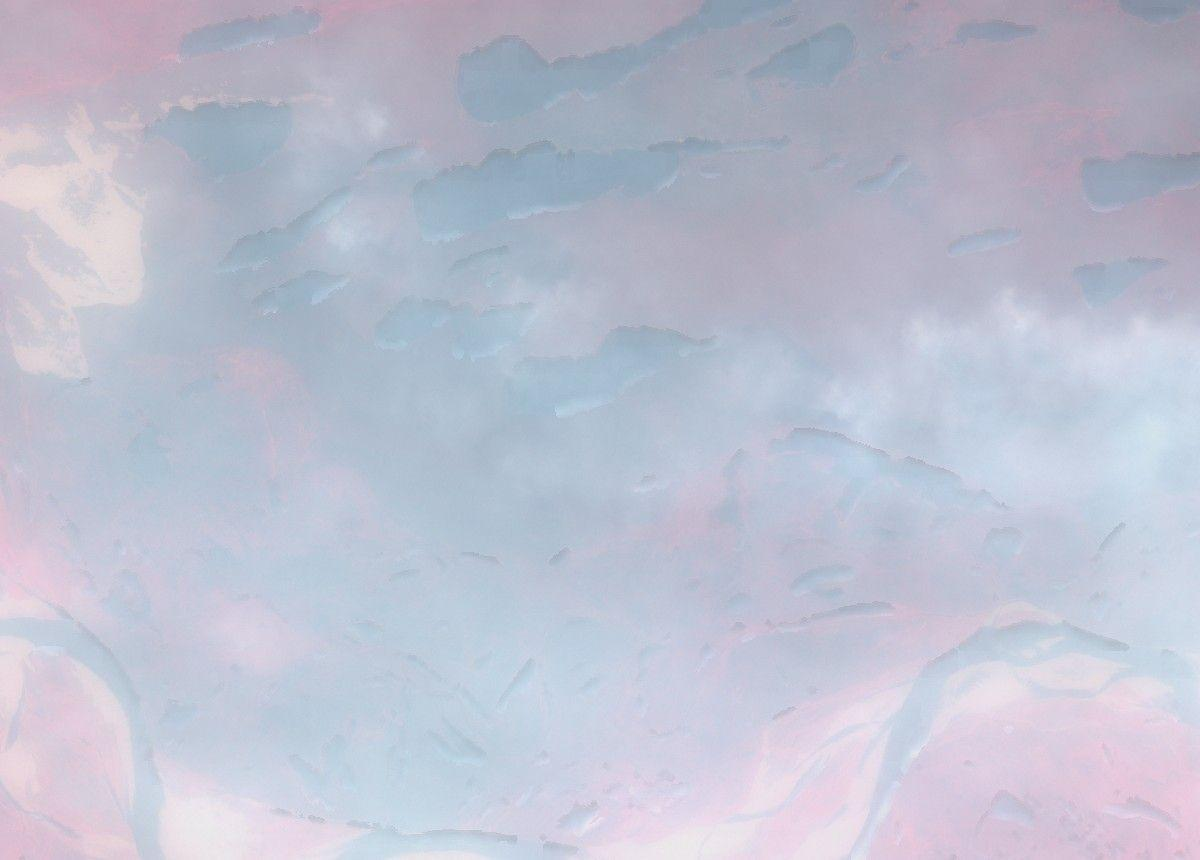

In [100]:
# - Afficher pour vérifier leur contenu par exemple avec : 

from PIL import Image
img = Image.open(fichiers_dans_dossier / "cl6b5x63r005il4551chxdt93_2_FALSE_COLOR_jpg.rf.8c4fb06b6812031edb1ad781ec14d2b9.jpg")
img.show()



In [101]:
df_bbox= df_annotations['bbox']
print(df_bbox)

df_annotations[['x','y','width','height']] = df_bbox.apply(pd.Series)
print(df_bbox)

0      [277, 207, 568.95, 591.79]
1        [800, 0, 157.45, 413.38]
2        [1062, 96, 58.37, 63.91]
3       [452, 442, 410.09, 350.6]
4        [0, 163, 336.16, 375.08]
                  ...            
954      [80, 30, 416.05, 183.75]
955      [0, 345, 140.33, 146.25]
956       [389, 361, 333, 340.52]
957     [510, 270, 222.6, 245.95]
958     [645, 519, 87.51, 126.38]
Name: bbox, Length: 959, dtype: object
0      [277, 207, 568.95, 591.79]
1        [800, 0, 157.45, 413.38]
2        [1062, 96, 58.37, 63.91]
3       [452, 442, 410.09, 350.6]
4        [0, 163, 336.16, 375.08]
                  ...            
954      [80, 30, 416.05, 183.75]
955      [0, 345, 140.33, 146.25]
956       [389, 361, 333, 340.52]
957     [510, 270, 222.6, 245.95]
958     [645, 519, 87.51, 126.38]
Name: bbox, Length: 959, dtype: object


In [102]:
def detecter_valeurs_aberrantes(df_annotations):
    """
    Vérifie les annotations pour détecter des valeurs aberrantes dans les colonnes 'x', 'y', 'width', 'height'.
    Critères :
    - width ou height <= 0 (trop petit ou négatif)
    - x ou y < 0 (coordonnées négatives)
    
    Args:
        df_annotations (pd.DataFrame): DataFrame contenant les colonnes 'x', 'y', 'width', 'height'.
    
    Returns:
        pd.DataFrame: sous-ensemble des annotations avec valeurs aberrantes.
    """
    # Conditions
    cond_width_height = (df_annotations['width'] <= 0) | (df_annotations['height'] <= 0)
    cond_position = (df_annotations['x'] < 0) | (df_annotations['y'] < 0)

    # Combine conditions
    aberrantes = df_annotations[cond_width_height | cond_position]

    return aberrantes


valeurs_aberrantes = detecter_valeurs_aberrantes(df_annotations)
print(valeurs_aberrantes)

Empty DataFrame
Columns: [id, image_id, category_id, bbox, area, segmentation, iscrowd, x, y, width, height]
Index: []


### c. Nettoyage

Dans le fichier data_cleaner.py :
- Choisir comment traiter ces anomalies du côté des images et du fichier .coco.json : 
    - On supprime les images sans annotations ? 
    - On ajoute des annotations vides s’il s’agit d’une image sans annotation ? etc
- Écrire les fonctions qui permettent de traiter les anomalies si besoin : 
    - suppression de fichier (os.remove), création et sauvegarde (json dumps) d’un fichier coco.json mis à jour

- Documenter les choix dans la doc.
Attention pour passer à l’étape suivante, il faut que chaque image ait une annotation associée dans le fichier et réciproquement.


Après visualisation des images sans annotations, je trouve que la visualisation de feu ou présence de feux étant moins concrètes que les autres images avec annotations 

In [103]:
 # Récupérer tous les image_id présents dans annotations
image_ids_avec_annotations = set(ann['image_id'] for ann in data.get('annotations', []))

print(image_ids_avec_annotations)

# Garder uniquement les images dont l'id est dans image_ids_avec_annotations
data['images'] = [img for img in data.get('images', []) if img['id'] in image_ids_avec_annotations]

print(data['images'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 2

In [104]:
def supprimer_images_sans_annotations(data):
    """
    Supprime les images sans aucune annotation du dictionnaire JSON COCO.

    Args:
        data (dict): dictionnaire JSON COCO {'images': [...], 'annotations': [...], 'categories': [...]}

    Returns:
        dict: dictionnaire avec images sans annotations supprimées
    """
    # Récupérer tous les image_id présents dans annotations
    image_ids_avec_annotations = set(ann['image_id'] for ann in data.get('annotations', []))

    # Garder uniquement les images dont l'id est dans image_ids_avec_annotations
    data['images'] = [img for img in data.get('images', []) if img['id'] in image_ids_avec_annotations]

    return data


df_annotations_suprimés = supprimer_images_sans_annotations(data)

print(df_annotations_suprimés)

{'info': {'year': '2025', 'version': '2', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2025-09-14T12:06:19+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'wildfire', 'supercategory': 'none'}, {'id': 1, 'name': 'fire', 'supercategory': 'wildfire'}], 'images': [{'id': 1, 'license': 1, 'file_name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf.95debd80b7509cc0a6afe0a7c7ff6cfe.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:19+00:00', 'extra': {'name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR.jpg'}}, {'id': 2, 'license': 1, 'file_name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf.fc96fcc9ef8466ce18f286d422df48ea.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:19+00:00', 'extra': {'name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR.jpg'}}, {'id': 3, '

In [105]:


def sauvegarder(data, chemin_fichier_sortie):
    """
    Sauvegarde le dictionnaire JSON COCO après supression des images sans anotations dans un nouveau fichier.
    
    Args:
        data (dict): dictionnaire JSON COCO à sauvegarder.
        chemin_fichier_sortie (str): chemin complet du fichier de sortie.
    """
    with open(chemin_fichier_sortie, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Fichier sauvegardé sous : {chemin_fichier_sortie}")

sauvegarder(df_annotations_suprimés, '/home/nabil_simplon/wildfire-detection/data/new_df.json' )

Fichier sauvegardé sous : /home/nabil_simplon/wildfire-detection/data/new_df.json


### Visualiser les données

→ Possibilité de le faire “à la main” avec matplotlib en affichant un rectangle à partir des coordonnées des annotations mais il existe plusieurs outils fait pour ce type de problème :

- Installer fiftyone dans votre environnement virtuel.
- Charger le dataset en utilisant `Dataset.from_dir()` en suivant l’exemple de la doc avec les chemins vers vos images et labels
- Lancer une session pour observer vos données et labels dans une app fiftyone :
session = fo.launch_app(dataset)


In [109]:
import os

chemin_images = "/"
chemin_annotations = "data/new_df.json"

# Vérifier que le dossier d'images existe
if not os.path.isdir(chemin_images):
    raise FileNotFoundError(f"Le dossier d'images n'existe pas ou est inaccessible : {chemin_images}")

# Vérifier que le fichier JSON d'annotations existe
if not os.path.isfile(chemin_annotations):
    raise FileNotFoundError(f"Le fichier d'annotations n'existe pas ou est inaccessible : {chemin_annotations}")

print(f"Les deux chemins existent et sont accessibles. {chemin_images}, et  {chemin_annotations}")


Les deux chemins existent et sont accessibles. /, et  data/new_df.json


In [111]:
import fiftyone as fo

# Chemins vers le dossier images et fichier d'annotations COCO JSON
chemin_images = ""
chemin_annotations = "data/new_df.json"

# Charger le dataset COCO depuis dossier et fichier d'annotations
dataset = fo.Dataset.from_dir(
    dataset_dir=chemin_images,
    dataset_type=fo.types.COCODetectionDataset,
    labels_path=chemin_annotations
)

# Lancer la session FiftyOne app
session = fo.launch_app(dataset)


 100% |█████████████████| 493/493 [2.1s elapsed, 0s remaining, 265.0 samples/s]      


### Pipeline de traitement de données

Dans un fichier pipeline.py : 
 - utiliser les fonctions précédentes pour faire la détection d’anomalie et le nettoyage des données et que ça puisse être utilisé par les 2 personnes du groupe pour avoir exactement le même traitement de données.

Test

Lire l’onglet test et chacun ajoute des tests sur au moins une fonction que vous avez codées.
